In [1]:
import xupy as xp
import numpy as np
import matplotlib.pyplot as plt

from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.analytical.pwfs_error_budget import ErrorBudget

from scipy.optimize import minimize


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [ ]:
# def find_best_Tint(error,lambdaInM,max_freq,mag,Nmodes,f_guess=None):
#     log_loss = lambda x,lambdaInM,Nmodes,mag: np.log(1-float(error.get_SR(lambdaInM,Nmodes,xp.asarray(x),mag)))
#     x0 = 1e-3
#     if f_guess is not None:
#         x0 = float(1/f_guess)
#     optout = minimize(log_loss, x0=x0, bounds = [(1/max_freq,1e-2)], args = (lambdaInM,Nmodes,mag))
#     return optout.x[0]

def find_best_Tint(error,lambdaInM,max_freq,mag,Nmodes,f_guess=None,f_step:float=50.0):
    f = max_freq if f_guess is None else f_guess
    new_loss = xp.log(1-float(error.get_SR(lambdaInM,Nmodes,1/f,mag)))
    f_best = f
    best_loss = new_loss + 1
    while f >= f_step and new_loss < best_loss:
        f_best = f
        best_loss = new_loss
        f = f-f_step
        new_loss = xp.log(1-float(error.get_SR(lambdaInM,Nmodes,1/f,mag)))
    return 1/f_best

def plot_error_budget(error,lambdaInM,Nmodes,T,mag_vec,optimize:bool=False):
    N = len(mag_vec)
    sig_tot = xp.zeros(N)
    sig_alias = xp.zeros(N)
    sig_meas = xp.zeros(N)
    sig_fit = xp.zeros(N)
    sig_temp = xp.zeros(N)

    if optimize:
        max_freq = 1/T
        f_vec = xp.ones(N)*max_freq

    for k,magV in enumerate(mag_vec):
        sig_tot[k], sig_alias[k], sig_fit[k], sig_meas[k], sig_temp[k] = error.sigma_tot(lambdaInM=lambdaInM,N=Nmodes,T=T,mag=magV)
        if optimize and sig_meas[k] >= sig_temp[k]:
            f_guess = None
            if k > 0:
                f_guess = f_vec[k-1]
            T = find_best_Tint(error,lambdaInM,max_freq,magV,Nmodes,f_guess)
            f_vec[k] = 1/T
            sig_tot[k], sig_alias[k], sig_fit[k], sig_meas[k], sig_temp[k] = error.sigma_tot(lambdaInM=lambdaInM,N=Nmodes,T=T,mag=magV)
    
    SR_vec = xp.exp(-((sig_tot*(2*xp.pi/lambdaInM))**2))

    plt.figure()
    plt.plot(xp.asnumpy(mag_vec),xp.asnumpy(SR_vec*1e+2),'-o')
    plt.grid()
    plt.xlabel('Star magnitude')
    plt.title(f'Strehl @ {lambdaInM*1e+9:1.0f} [nm]')

    plt.figure()
    plt.plot(xp.asnumpy(mag_vec),xp.asnumpy(sig_fit*1e+9),'-o',label='fitting')
    plt.plot(xp.asnumpy(mag_vec),xp.asnumpy(sig_meas*1e+9),'-o',label='measurement')
    plt.plot(xp.asnumpy(mag_vec),xp.asnumpy(sig_temp*1e+9),'-o',label='temporal')
    plt.plot(xp.asnumpy(mag_vec),xp.asnumpy(sig_alias*1e+9),'-o',label='aliasing')
    plt.plot(xp.asnumpy(mag_vec),xp.asnumpy(sig_tot*1e+9),'--',label='total')
    plt.legend()
    plt.yscale('log')
    plt.grid()
    plt.ylabel('error [nm]')
    plt.xlabel('Star magnitude')

    if optimize:
        return f_vec

In [3]:
V = 10
RON = 0.4
dark = 0.0
F = 1
thrp = 0.11*0.2*0.9
camera = (RON,dark,F,thrp)

f_dm = 2000
t_rtc = 150e-6
f_camera = 2067
delay = (1/f_camera,t_rtc,1/f_dm)

In [4]:
ssao = SingleStageAO(tn='error_budget')
# ssao.initialize_turbulence()
ssao.pyr.set_modulation_angle(ssao.sc.modulationAngleInLambdaOverD)
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=2)
Rec, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, amps=0.002)
r0s = ssao.atmo_pars['r0']
L0 = ssao.atmo_pars['outerScaleInM']
subap_masks = ssao.sc._roi_masks.copy()
input_field = (1-ssao.cmask) * xp.exp(1j*(1-ssao.cmask))
image = ssao.pyr.get_intensity(input_field,ssao.pyr.lambdaInM/ssao.pupilSizeInM)
frame = ssao.ccd.image_on_detector(image)

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps


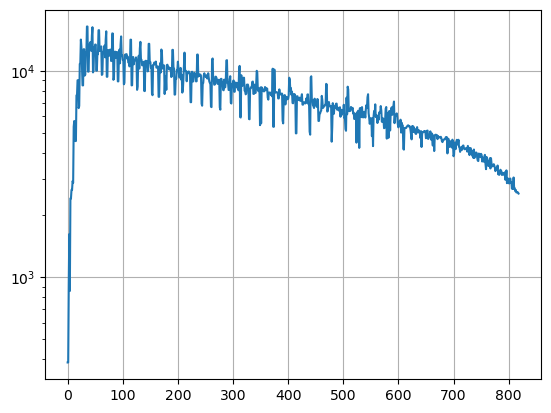

In [5]:
DtD = IM.T @ IM
plt.figure()
plt.plot(xp.asnumpy(xp.diag(DtD)))
plt.grid()
plt.yscale('log')

In [6]:
freq = xp.logspace(-4,4,2000)
Nmodes = 800

error = ErrorBudget(r0s,L0,V,ssao.pupilSizeInM,delay,camera,IM,frame,subap_masks)
error.update_freq_range(freq)
error.define_aliasing_variance(r0s, ssao.cmask, ssao.sc, ssao.pyr.lambdaInM, ssao.pupilSizeInPixels, KL, N=5, Nmodes=Nmodes)
ssao.sc.Rec = xp.linalg.pinv(IM)
_, cl_opt_gains, _ = ssao.calibrate_optical_gains(N=5, slope_computer=ssao.sc, MM=KL, amps=0.002)

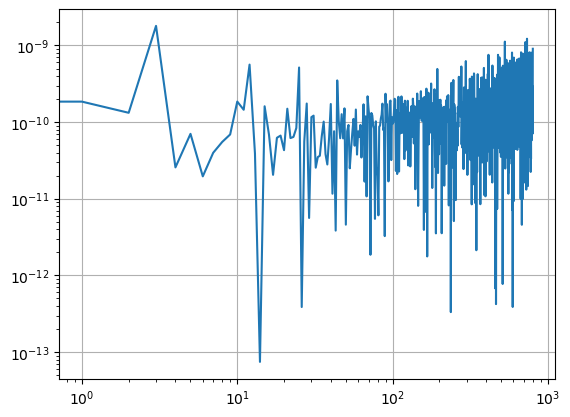

In [7]:
sig_alias_nm = xp.sqrt(error.sig2_alias)*800e-9/(2*xp.pi)

plt.figure()
plt.plot(xp.asnumpy(sig_alias_nm))
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [8]:
f = 1500
G = 1
mag = 2
lambdaInM = 750e-9

gains = xp.ones(Nmodes)
error.set_loop_gains(gains*G, 1/f)
error.load_optical_gains(1/cl_opt_gains)#gains)

sig_tot, sig_alias, sig_fit, sig_meas, sig_temp = error.sigma_tot(lambdaInM,N=Nmodes,T=1/f,mag=mag)
print(sig_tot, sig_alias, sig_fit, sig_meas, sig_temp)

9.191481563900975e-08 7.376361067821018e-09 2.3031709994434535e-08 8.712738199123349e-08 1.6500977953934493e-08


1450.0
1400.0
1350.0
1300.0
1250.0
1200.0
1150.0
1100.0
1050.0
1000.0
950.0
1450.0
1400.0
1350.0
1300.0
1250.0
1200.0
1150.0
1100.0
1050.0
1000.0
950.0
900.0
850.0
800.0
750.0
700.0
650.0
600.0
550.0
550.0
500.0
450.0
400.0
400.0
350.0
300.0
1450.0
1400.0
1350.0
1300.0
1250.0
1200.0
1150.0
1100.0
1050.0
1000.0
950.0
900.0
850.0
800.0
750.0
700.0
650.0
600.0
550.0
500.0
450.0
400.0
350.0
300.0
250.0
200.0
200.0
150.0
150.0
100.0
100.0
50.0
1450.0
1450.0
1450.0
1450.0
1450.0
1450.0
1450.0
1450.0
1450.0
1450.0
1450.0
1450.0


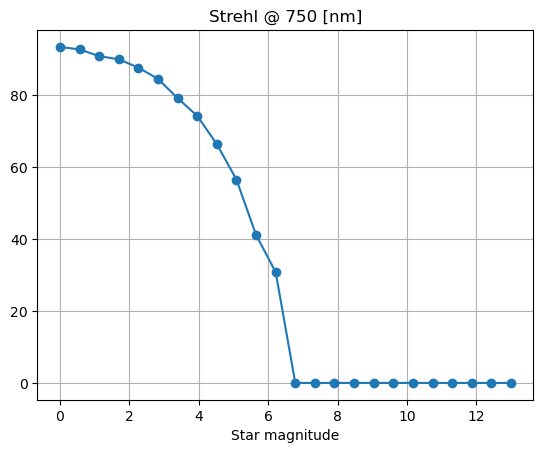

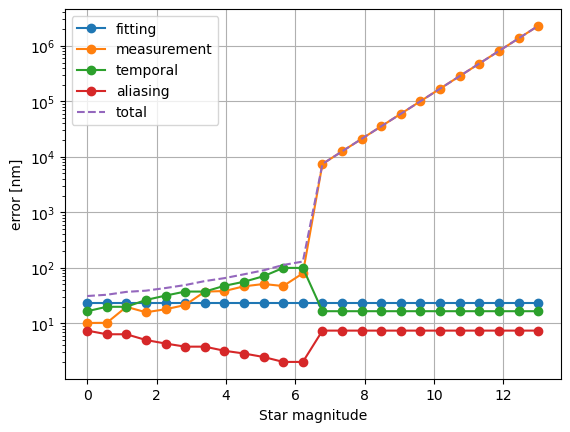

In [ ]:
# mag_vec = xp.linspace(0,13,24)
# best_f = plot_error_budget(error,lambdaInM=lambdaInM,Nmodes=Nmodes,T=1/f,mag_vec=mag_vec,optimize=True)
# print(best_f)

[1500. 1000. 1500.  600.  450.  350. 1500.  250.  200.  150.  100. 1500.
 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.]
